# Loading Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%precision %.2f
import re

# Importing required libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# keras
from keras.models import Sequential
from keras.layers import Dense

from keras.layers.core import Reshape, Flatten
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## 1. Loading Data

In [2]:
df = pd.read_csv("../input/lemmatized-reviews/lemsen_imdb.csv")

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df['review_words'],df['sentiment'],test_size=0.4, random_state=123)

X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=123)

In [4]:
X_train.shape

(30000,)

In [5]:
np.asarray(y_train)

array(['negative', 'positive', 'positive', ..., 'positive', 'positive',
       'negative'], dtype=object)

In [6]:
from sklearn.preprocessing import LabelEncoder

Encoder = LabelEncoder()
y_train = Encoder.fit_transform(y_train)
y_val = Encoder.fit_transform(y_val)
y_test = Encoder.fit_transform(y_test)

### 2. Convert data to tfidf

In [7]:
vect = TfidfVectorizer(decode_error='ignore')
train_tfidf = vect.fit_transform(X_train)
val_tfidf = vect.transform(X_val)
test_tfidf = vect.transform(X_test)


In [8]:
train_tfidf.shape[1]

66682

In [9]:
train_tfidf

<30000x66682 sparse matrix of type '<class 'numpy.float64'>'
	with 2934649 stored elements in Compressed Sparse Row format>

# Build network and train it untill validation loss reduces (EarlyStopping)

In [10]:
ip_dim = train_tfidf.shape[1]

model = Sequential()
model.add(Dense(64, input_dim=ip_dim, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# Compiling Model using optimizer
opt = Adam(lr=1e-3)
model.compile(loss='binary_crossentropy',optimizer=opt)

# Fitting Model to the data
callbacks = [EarlyStopping(monitor='val_loss')]
hist_adam = model.fit(train_tfidf, np.asarray(y_train), batch_size=1000, epochs=20, verbose=2, validation_data=(val_tfidf, np.asarray(y_val)),
         callbacks=callbacks)  # starts training

Train on 30000 samples, validate on 10000 samples
Epoch 1/20
 - 37s - loss: 0.6294 - val_loss: 0.5205
Epoch 2/20
 - 30s - loss: 0.3757 - val_loss: 0.3154
Epoch 3/20
 - 30s - loss: 0.1971 - val_loss: 0.2607
Epoch 4/20
 - 29s - loss: 0.1211 - val_loss: 0.2548
Epoch 5/20
 - 30s - loss: 0.0779 - val_loss: 0.2690


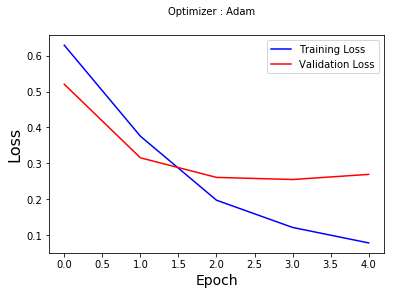

In [12]:
#plotting Loss
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.plot(hist_adam.history['loss'], color='b', label='Training Loss')
plt.plot(hist_adam.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# Predict on test data

In [13]:
# Predict on train, val and test datasets
pred_train = model.predict(train_tfidf)
pred_test = model.predict(test_tfidf)
pred_val = model.predict(val_tfidf)

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve

In [15]:
AUC = np.array([roc_auc_score(y_train, pred_train),
                roc_auc_score(y_val, pred_val),
                roc_auc_score(y_test, pred_test)])
AUC

array([0.9988684 , 0.95885101, 0.96068657])

In [16]:
fpr, tpr, thresholds = roc_curve(y_test, pred_test)

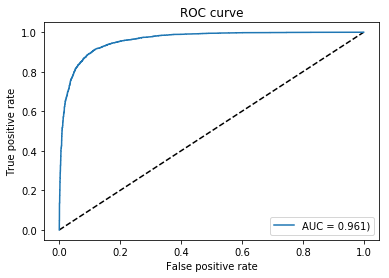

In [17]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f})'.format(AUC[2]))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [18]:
pred_test = (pred_test > 0.5).astype("int32").ravel()

In [19]:
print( "Accuracy -> ", accuracy_score(y_test, pred_test), 
       "\nPrecision -> ", precision_score(y_test, pred_test),
       "\nRecall -> ", recall_score(y_test, pred_test),
       "\nF1-Score -> ", f1_score(y_test, pred_test))

Accuracy ->  0.8937 
Precision ->  0.8730279414559969 
Recall ->  0.9208099438652767 
F1-Score ->  0.8962825641526003


In [20]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [21]:
cm = confusion_matrix(y_true= y_test, y_pred=pred_test)
plot_labels = [0,1]

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], fontsize= 'xx-large',
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

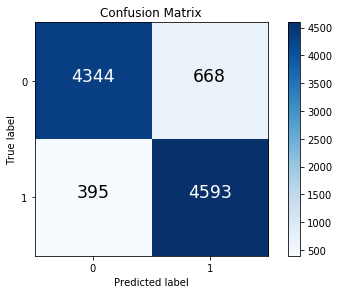

In [23]:
plot_confusion_matrix(cm=cm, classes=plot_labels, title='Confusion Matrix') 